In [3]:
#Importing required libraries
import pandas as pd
import numpy as np
from sklearn import metrics 
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.cluster import MiniBatchKMeans, KMeans 
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score 
from sklearn.decomposition import PCA 
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score
from feature_selector import FeatureSelector
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from coclust.evaluation.external import accuracy
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
import seaborn as sns
sns.set() 
%matplotlib inline 

C:\Users\786\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\linear_assignment_.py:21: DeprecationWarning: The linear_assignment_ module is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


In [8]:
data = pd.read_excel(r"C:\Users\786\Desktop\reserch\features-only.xlsx")
#Creating data frame
df = data.copy()
#Dropping unrequired features
df = df.drop(['Name', 'md5', 'malicious'], axis=1)
#Storing ground truth values for evaluation
labels=data['malicious'].values

In [9]:
#Keeping only those features with correlation less than 0.57 for better clustering
fs = FeatureSelector(data = df, labels = df.columns)
fs.identify_collinear(correlation_threshold=0.57)
correlated_features = fs.ops['collinear']
correlated_features[:5]

23 features with a correlation magnitude greater than 0.57.



['SizeOfOptionalHeader',
 'SizeOfInitializedData',
 'SizeOfUninitializedData',
 'BaseOfCode',
 'BaseOfData']

In [10]:
#Dropping features with correlation greater than 0.57
df = fs.remove(methods = ['collinear'])

Removed 23 features.


In [11]:
#determining the number of remaining features
len([col for col in df.columns if not df[col].is_unique])

34

In [12]:
df = df.loc[:, (df != 0).any(axis=0)]

In [13]:
columns = df.columns

In [8]:
df.head()

,Machine,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,AddressOfEntryPoint,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,...,SectionsMinRawsize,SectionsMinVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMeanSize,ResourcesMinSize
0,332,258,10,0,897024,5210872,4194304,4096,512,5,...,5120,8192,9,10,0,0,135,5.779969,1609.555556,46
1,332,271,7,10,42496,18049,4194304,4096,512,4,...,6656,8192,1,4,0,0,23,0.629766,921.652174,20
2,332,259,10,0,339456,4096,4194304,4096,512,5,...,31232,32768,1,4,0,0,150,0.221024,4868.413333,2
3,332,527,2,56,380824,4672,4194304,4096,512,4,...,6656,8192,1,4,0,0,6,2.084803,130995.333300,20
4,332,527,2,56,380824,4672,4194304,4096,512,4,...,6656,8192,1,4,0,0,6,0.751531,20655.500000,20


In [14]:
df.dtypes

Machine                          int64
Characteristics                  int64
MajorLinkerVersion               int64
MinorLinkerVersion               int64
SizeOfCode                       int64
AddressOfEntryPoint              int64
ImageBase                        int64
SectionAlignment                 int64
FileAlignment                    int64
MajorOperatingSystemVersion      int64
MinorOperatingSystemVersion      int64
MajorImageVersion                int64
MinorImageVersion                int64
MinorSubsystemVersion            int64
SizeOfImage                      int64
Subsystem                        int64
DllCharacteristics               int64
SizeOfStackReserve               int64
SizeOfStackCommit                int64
SizeOfHeapCommit                 int64
SectionsNb                       int64
SectionsMeanEntropy            float64
SectionsMinRawsize               int64
SectionsMinVirtualsize           int64
ImportsNbDLL                     int64
ImportsNb                

In [15]:
#Using minmax scaling so that all the features lie on the same scale
scaler = MinMaxScaler()
new=scaler.fit_transform(df) #fit and transform the values
scaled=pd.DataFrame(columns=df.columns,data=new) #convert the scaled values into the dataframe
scaled.head()

,Machine,Characteristics,MajorLinkerVersion,MinorLinkerVersion,SizeOfCode,AddressOfEntryPoint,ImageBase,SectionAlignment,FileAlignment,MajorOperatingSystemVersion,...,SectionsMinRawsize,SectionsMinVirtualsize,ImportsNbDLL,ImportsNb,ImportsNbOrdinal,ExportNb,ResourcesNb,ResourcesMeanEntropy,ResourcesMeanSize,ResourcesMinSize
0,0.0,0.005421,0.120482,0.000000,0.000473,0.197981,4.697119e-07,0.499022,0.121569,0.444444,...,0.001699,0.000612,0.102564,0.001523,0.0,0.0,0.106719,0.723437,0.000187,0.000624
1,0.0,0.005735,0.084337,0.054645,0.000022,0.000686,4.697119e-07,0.499022,0.121569,0.333333,...,0.002208,0.000612,0.000000,0.000508,0.0,0.0,0.018182,0.078823,0.000107,0.000271
2,0.0,0.005445,0.120482,0.000000,0.000179,0.000156,4.697119e-07,0.499022,0.121569,0.444444,...,0.010361,0.002447,0.000000,0.000508,0.0,0.0,0.118577,0.027664,0.000567,0.000027
3,0.0,0.011930,0.024096,0.306011,0.000201,0.000178,4.697119e-07,0.499022,0.121569,0.333333,...,0.002208,0.000612,0.000000,0.000508,0.0,0.0,0.004743,0.260940,0.015251,0.000271
4,0.0,0.011930,0.024096,0.306011,0.000201,0.000178,4.697119e-07,0.499022,0.121569,0.333333,...,0.002208,0.000612,0.000000,0.000508,0.0,0.0,0.004743,0.094064,0.002405,0.000271


In [16]:
#Functions
def kmeans_clustering(features):
    clusters = 2
    k_mean = KMeans(n_clusters=clusters)
    k_mean.fit_predict(features)
    pred = df.copy()    
    pred['k_mean'] = k_mean.labels_
   # pred
    print(pred['k_mean'].value_counts())
    predicted_labels=k_mean.labels_
    print(k_mean.labels_[:])
    cm = confusion_matrix(labels, predicted_labels)
    ax = sns.heatmap(cm, annot=True, fmt="d") #cmap="Reds")
    print("Accuracy of k-means clustering:",accuracy(labels, predicted_labels))
    print("Silhoutte score of k-means clustering: ",metrics.silhouette_score(scaled, k_mean.labels_))
    print("Davies Bouldin score of k-means clustering: ",davies_bouldin_score(scaled, predicted_labels)) 

def agglomerative_clustering(features):
    clusters = 2
    agglo_model = AgglomerativeClustering(n_clusters=clusters)
    agglo_model.fit_predict(features)
    pred = df.copy() 
    pred['agglo_model'] = agglo_model.labels_
    #print(model.labels_[:])
    print (pred['agglo_model'].value_counts())
    agglo_predicted_labels=agglo_model.labels_
    print(agglo_model.labels_[:])
    cm = confusion_matrix(labels, agglo_predicted_labels)
    ax = sns.heatmap(cm, annot=True, fmt="d") #cmap="Reds")
    print("Accuracy of agglomerative clustering:",accuracy(labels, agglo_predicted_labels))
    print("Silhoutte score of agglomerative clustering: ",metrics.silhouette_score(scaled,agglo_predicted_labels))
    print("Davies Bouldin score of agglomerative clustering: ",davies_bouldin_score(scaled, agglo_predicted_labels)) 

def spectral_clustering(features):
    clusters = 2
    spectral=SpectralClustering(n_clusters=clusters,assign_labels='kmeans')
    spectral.fit_predict(features)
    pred = df.copy() 
    pred['spectral'] = spectral.labels_
    #print(model.labels_[:])
    print (pred['spectral'].value_counts())
    spectral_predicted_labels=spectral.labels_
    print(spectral.labels_[:])
    cm = confusion_matrix(labels, spectral_predicted_labels)
    ax = sns.heatmap(cm, annot=True, fmt="d") #cmap="Reds")
    print("Accuracy of spectral clustering:",accuracy(labels, spectral_predicted_labels))
    print("Silhoutte score of spectral clustering: ",metrics.silhouette_score(scaled, spectral_predicted_labels))
    print("Davies Bouldin score of spectral clustering: ",davies_bouldin_score(scaled, spectral_predicted_labels)) 
    
def kmeans_mini_batch_clustering(features):
    batch_size = 45
    mini_kmeans = MiniBatchKMeans(init ='k-means++', n_clusters = 2, batch_size = batch_size, n_init = 10, max_no_improvement = 10, verbose = 0) 
    mini_kmeans.fit_predict(features)
    pred = df.copy() 
    pred['mini_kmeans'] = mini_kmeans.labels_
    #print(model.labels_[:])
    print (pred['mini_kmeans'].value_counts())
    mini_kmeans_predicted_labels=mini_kmeans.labels_
    print(mini_kmeans.labels_[:])
    cm = confusion_matrix(labels,   mini_kmeans_predicted_labels)
    ax = sns.heatmap(cm, annot=True, fmt="d") #cmap="Reds")
    print("Accuracy of k-means-mini clustering:",accuracy(labels, mini_kmeans_predicted_labels))
    print("Silhoutte score of k-means-mini clustering: ",metrics.silhouette_score(scaled, mini_kmeans_predicted_labels))
    print("Davies Bouldin score of k-means-mini clustering: ",davies_bouldin_score(scaled, mini_kmeans_predicted_labels)) 
    
#def P_C_A(feature_count,features):
 #   pca = PCA(feature_count) 
  #  pca.fit(features) 
  #  pca_data = pd.DataFrame(pca.transform(features)) 
  #  pca_data.columns = ['P1','P2','P3'] 
   # print(pca_data.head())
    
def dendrogram():
    plt.figure(figsize =(8, 8)) 
    plt.title('Visualising the data') 
    Dendrogram = shc.dendrogram((shc.linkage(pca_data, method ='ward'))) 

def data_correlation_2d():
    fig, ax = plt.subplots(figsize=(15,15)) 
    # generating correlation heatmap 
    sns.heatmap(scaled.corr(), annot = True,linewidths=.5, ax=ax) 
     # posting correlation heatmap to output console 
    plt.figure(figsize=(16,16))
    plt.show() 
    
#def data_correlation_3d():
def kmean_visualization():
    ac2 = KMeans(n_clusters = 2) 
    plt.figure(figsize =(6, 6)) 
    plt.scatter(pca_data['P1'],pca_data['P2'], c = ac2.fit_predict(pca_data),cmap ='jet') 
    plt.title("K-Means Clustering")
    plt.show() 
    
def kmean_visualization():
    ac2 = KMeans(n_clusters = 2) 
    plt.figure(figsize =(6, 6)) 
    plt.scatter(pca_data['P1'],pca_data['P2'], c = ac2.fit_predict(pca_data),cmap ='jet') 
    plt.title("K-Means Clustering")
    plt.show() 
    
def agglomerative_visualization():
    ac3 = AgglomerativeClustering(n_clusters=2)
    plt.figure(figsize =(6, 6)) 
    plt.scatter(pca_data['P1'],pca_data['P2'], c = ac3.fit_predict(pca_data),cmap ='jet') 
    plt.title("Agglomerative Clustering")
    plt.show() 
    
def spectral_visualization():
    ac4 = SpectralClustering(n_clusters=2,assign_labels='kmeans')
    plt.figure(figsize =(6, 6)) 
    plt.scatter(pca_data['P1'],pca_data['P2'], c = ac4.fit_predict(pca_data),cmap ='jet') 
    plt.title("Spectral Clustering")
    plt.show() 
    
def k_mini_batch_visualization():
    batch_size = 45
    ac5 = MiniBatchKMeans(init ='k-means++', n_clusters = 2, batch_size = batch_size, n_init = 10, max_no_improvement = 10, verbose = 0) 
    plt.figure(figsize =(6, 6)) 
    plt.scatter(pca_data['P1'],pca_data['P2'], c = ac5.fit_predict(pca_data),cmap ='jet') 
    plt.title("K-Mini Batch  Clustering")
    plt.show() 
    
def Elbow_plot():
    cost = []
    for k in range(1, 15):
        kmeanModel = KMeans(n_clusters=k, random_state=0).fit(scaled)
        cost.append([k,kmeanModel.inertia_])
    plt.figure(figsize=(15,6))
    sns.set_context('poster')
    plt.plot(pd.DataFrame(cost)[0], pd.DataFrame(cost)[1])
    plt.xlabel('k')
    plt.ylabel('Cost')
    plt.title('The Elbow Method showing the optimal k') 
    plt.show()
    
def GMM_Full():
    gmm = GaussianMixture(n_components=2,covariance_type='full', random_state=42)
    gmm.fit_predict(scaled)
    labelsfull=gmm.fit_predict(scaled)
    score = adjusted_rand_score(labels,labelsfull)
    print("Accuracy score using covariance_type :full ",score)

def GMM_Tied():
    gmm = GaussianMixture(n_components=2,covariance_type='tied', random_state=42)
    gmm.fit_predict(scaled)
    labelstied=gmm.fit_predict(scaled)
    score = adjusted_rand_score(labels,labelstied)
    print("Accuracy score using covariance_type :tied ",score)
    
def GMM_Spherical():
    gmm = GaussianMixture(n_components=2,covariance_type='spherical', random_state=42)
    gmm.fit_predict(scaled)
    labelspherical=gmm.fit_predict(scaled)
    score = adjusted_rand_score(labels,labelspherical)
    print("Accuracy score using covariance_type : spherical ",score)
   
    
def GMM_Diag():
    gmm = GaussianMixture(n_components=2,covariance_type='diag', random_state=42)
    labeldiag=gmm.fit_predict(scaled)
    score = adjusted_rand_score(labels,labeldiag)
    print("Accuracy score using covariance_type : diag: ",score)
    
    
def GMM_Full_CV():
    gmm = GaussianMixture(n_components=2,covariance_type='full',random_state=42)
    score_full=cross_val_score(gmm, scaled, labels, cv=5,scoring='accuracy')
    scoref = np.average(score_full)
    print("Accuracy score using covariance_type :full ",scoref)

def GMM_Tied_CV():
    gmm = GaussianMixture(n_components=2,covariance_type='tied',random_state=42)
    score_tied=cross_val_score(gmm, scaled, labels, cv=5,scoring='accuracy')
    score_t=np.average(score_tied)
    print("Accuracy score using covariance_type :tied ",score_t)
    
def GMM_Spherical_CV():
    gmm = GaussianMixture(n_components=2,covariance_type='spherical', random_state=42)
    score_spherical=cross_val_score(gmm, scaled, labels, cv=5,scoring='accuracy')
    score_s = np.average(score_spherical)
    print("Accuracy score using covariance_type : spherical ",score_s)
   
    
def GMM_Diag_CV():
    gmm = GaussianMixture(n_components=2,covariance_type='diag', random_state=42)
    score_diag=cross_val_score(gmm, scaled, labels, cv=5,scoring='accuracy')
    score_d = np.average(score_diag)
    print("Accuracy score using covariance_type : spherical ",score_d)
   
    

In [17]:
#Reducing data dimensionality
pca = PCA(3) 
pca.fit(scaled) 
pca_data = pd.DataFrame(pca.transform(scaled)) 
pca_data.columns = ['P1','P2','P3'] 
print(pca_data.head())

         P1        P2        P3
0  0.093471  0.514307 -0.195093
1 -0.367035 -0.059912  0.043139
2 -0.097083  0.481074 -0.131739
3 -0.221337 -0.102813  0.032826
4 -0.294159 -0.095940  0.049084


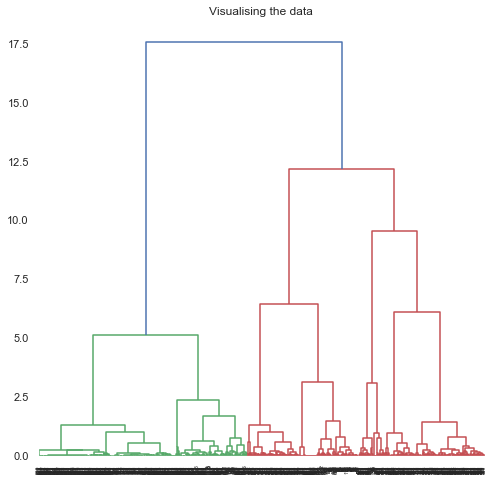

In [17]:
#Visulaization that the data is linearly seperable
dendrogram()

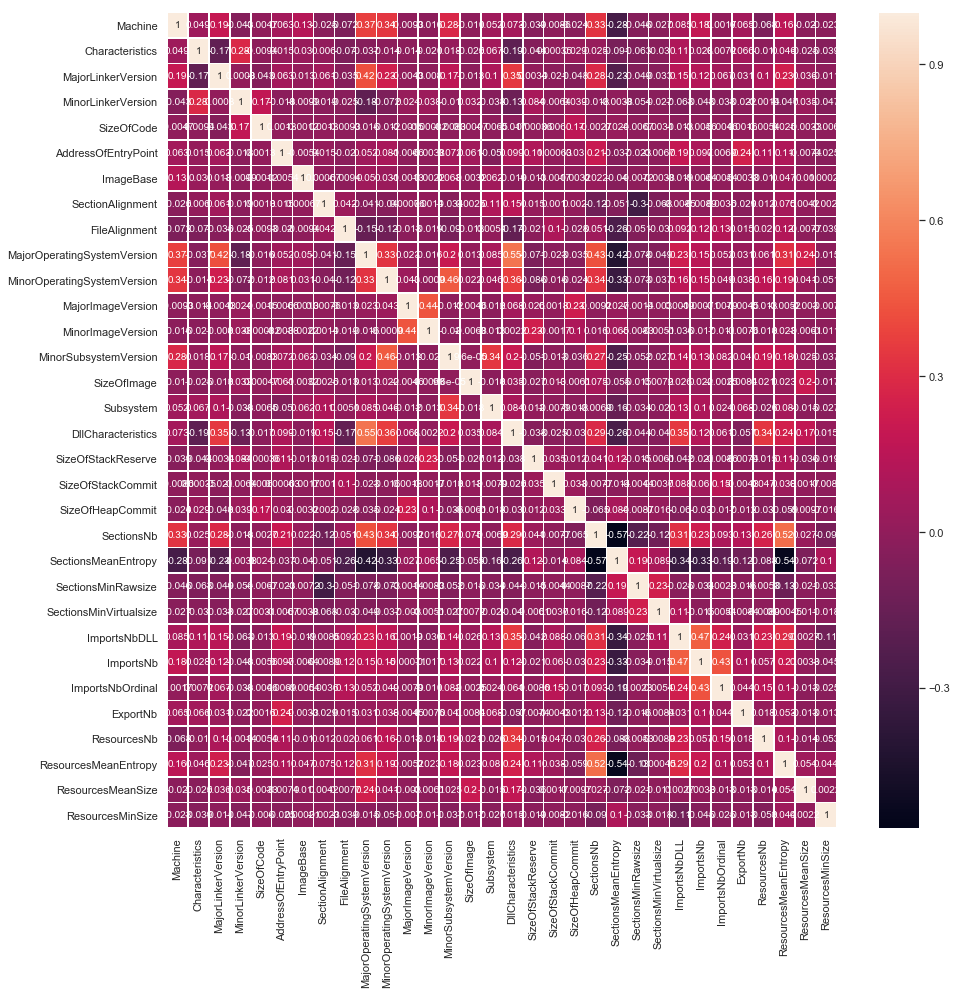

<Figure size 1152x1152 with 0 Axes>

In [18]:
#2d correlation of the dataset
data_correlation_2d()

In [ ]:
##########################################################################################################################
                         # UNSUPERVISED ALGORITHMS WITHOUT CROSS VALIDATION #

0    516
1    484
Name: k_mean, dtype: int64
[1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 

C:\Users\786\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


Silhoutte score of k-means clustering:  0.35485763000580794
Davies Bouldin score of k-means clustering:  1.2931950306695674


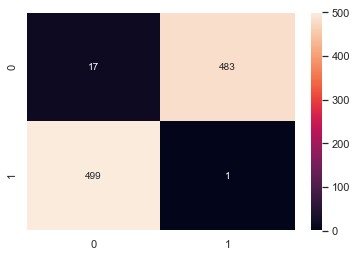

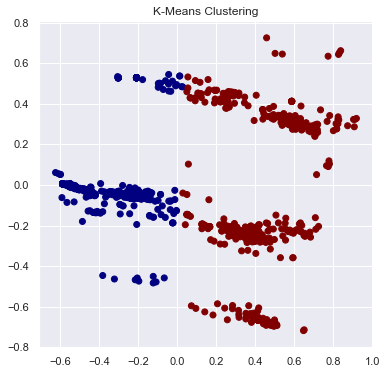

In [19]:
                                                # K-MEANS #
kmeans_clustering(scaled)
kmean_visualization()

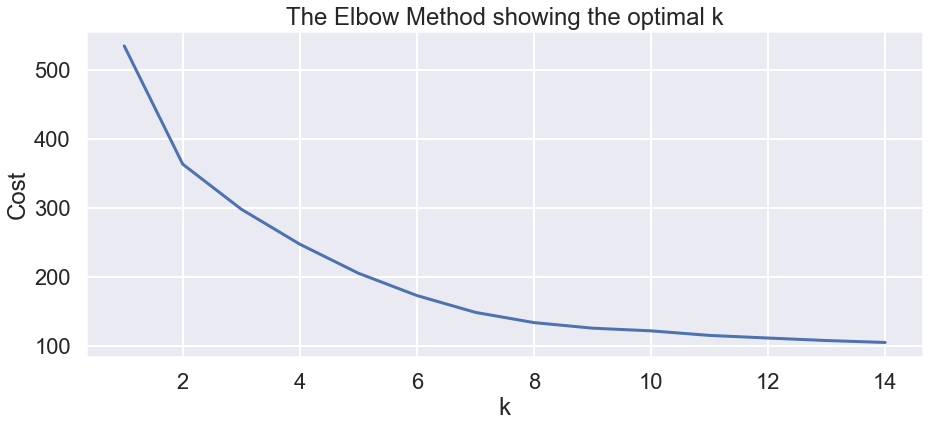

In [20]:
#Elbow plot to find the optimal 'k' value
Elbow_plot()

0    560
1    440
Name: agglo_model, dtype: int64
[0 1 0 1 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\786\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


 1.3036637278735514


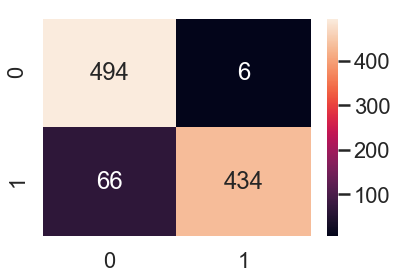

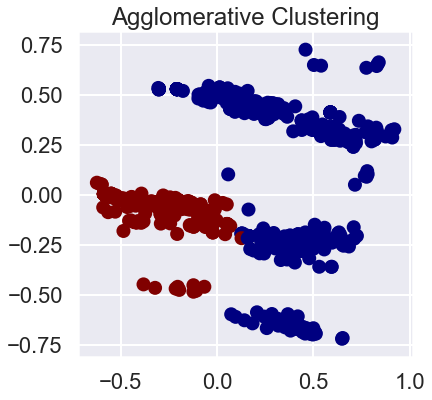

In [23]:
                                          # AGGLOMERATIVE CLUSTERING #
agglomerative_clustering(scaled)
agglomerative_visualization()

1    515
0    485
Name: mini_kmeans, dtype: int64
[0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

C:\Users\786\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


 0.35481965670564786
Davies Bouldin score of k-means-mini clustering:  1.2925075983761511


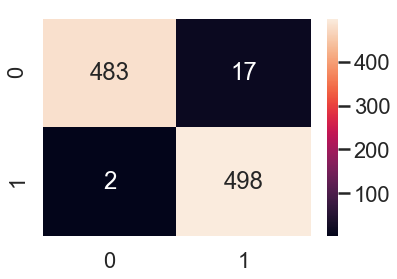

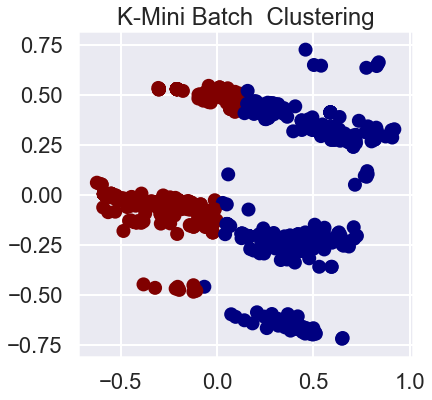

In [29]:
                                         # K-MEANS MINI BATCH #
    
kmeans_mini_batch_clustering(scaled)
k_mini_batch_visualization()

1    524
0    476
Name: spectral, dtype: int64
[0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 1 1 1 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

C:\Users\786\AppData\Roaming\Python\Python37\site-packages\sklearn\utils\linear_assignment_.py:127: DeprecationWarning: The linear_assignment function is deprecated in 0.21 and will be removed from 0.23. Use scipy.optimize.linear_sum_assignment instead.
  DeprecationWarning)


 0.3538877678994827
Davies Bouldin score of spectral clustering:  1.3027292105794102


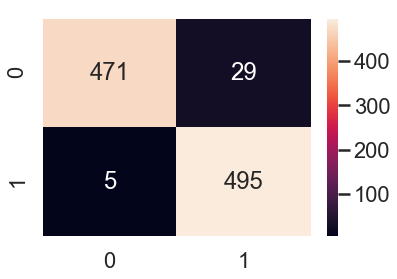

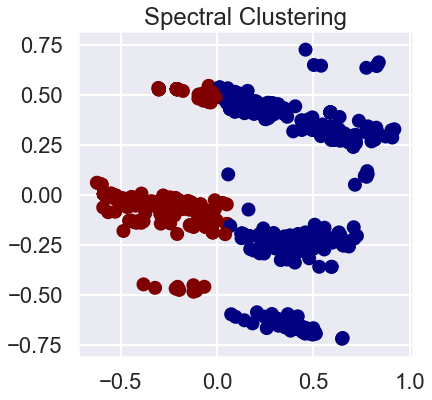

In [27]:
                                         # SPECTRAL CLUSTERING #
    
spectral_clustering(scaled)
spectral_visualization()

In [ ]:
##########################################################################################################################
                         # UNSUPERVISED ALGORITHMS WITH CROSS VALIDATION #

In [31]:
clusters = 2
k_mean = KMeans(n_clusters=clusters)
score=cross_val_score(k_mean, scaled, labels, cv=5,scoring='accuracy')
np.average(score)


0.366

In [33]:
clusters = 2
agglo_model = AgglomerativeClustering(n_clusters=clusters).fit(scaled)
score1=cross_val_score(agglo_model, scaled, labels, cv=5,scoring='accuracy')
np.average(score1)

AttributeError: 'AgglomerativeClustering' object has no attribute 'predict'

In [34]:
clusters = 2
spectral=SpectralClustering(n_clusters=clusters,assign_labels='kmeans')
score2=cross_val_score(spectral, scaled, labels, cv=5,scoring='accuracy')
np.average(score2)

AttributeError: 'SpectralClustering' object has no attribute 'predict'

In [36]:
batch_size = 45
mini_kmeans = MiniBatchKMeans(init ='k-means++', n_clusters = 2, batch_size = batch_size, n_init = 10, max_no_improvement = 10, verbose = 0)
score3=cross_val_score(mini_kmeans, scaled, labels, cv=5,scoring='accuracy')
np.average(score3)

0.5650000000000001

In [ ]:
           #########################   GAUSSIAN MIXTURE MODEL- WITHOUT CROSS VALIDATION   ###################

In [48]:
GMM_Full()

Accuracy score using covariance_type :full  0.8499339188972675


In [51]:
GMM_Tied()

Accuracy score using covariance_type :tied  0.9369609624769283


In [52]:
GMM_Spherical()

Accuracy score using covariance_type : spherical  0.2615808678214564


In [53]:
GMM_Diag()

Accuracy score using covariance_type : diag:  0.8499339188972675


Accuracy score using covariance_type :full  0.8499339188972675


In [ ]:
          #########################   GAUSSIAN MIXTURE MODEL -  WITH CROSS VALIDATION   ###################

In [57]:
GMM_Full_CV()

Accuracy score using covariance_type :full  0.898


In [59]:
GMM_Tied_CV()

Accuracy score using covariance_type :tied  0.8400000000000001


In [60]:
GMM_Spherical_CV()

Accuracy score using covariance_type : spherical  0.9129999999999999


In [58]:
GMM_Diag_CV()

Accuracy score using covariance_type : spherical  0.869
